# Gradient descent on bandwidth parameter (1-dim)

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, jacfwd, jacrev
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

from svgd import SVGD
from metrics import ksd
import time

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


cpu


In [2]:
n=100
d=1
stepsize = 0.01
n_iter_max = 500 # 100 slightly to little, this should be all right
# grid_length = 25
bandwidth = 1

from jax.scipy.stats import norm

@jit
def logp(x):
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1)) 

from svgd import get_bandwidth

svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.c

# Define optimizer and utilities

In [3]:
svgd_stepsize = stepsize

In [4]:
def sweep(rkey, grid, sample_each_time=False, joint_param=False, average_over=1):
    """Sweep a grid of bandwidth values and output corresponding metrics.
    Arguments:
    * average_over: integer, compute average over m random seeds
    """
    if average_over == 1:
        sweep_results = []
        if sample_each_time:
            rkeys = random.split(svgd_fix.rkey, len(grid))
        else:
            rkeys = [rkey] * len(grid)

        for rkey, h in tqdm(zip(rkeys, grid)):
            if joint_param:
                l = svgd_fix.loss(rkey, h, h)
                gl = jacfwd(svgd_fix.loss, argnums=1)(rkey, h, h)
            else:
                l = svgd_fix.loss(rkey, h)
                gl = jacfwd(svgd_fix.loss, argnums=1)(rkey, h)

            sweep_results.append([l, gl])

        sweep_results = np.array(sweep_results)
    else:
        ress = []
        for _ in range(average_over):
            rkey = random.split(rkey)[0]
            res = sweep(rkey, grid, sample_each_time=False, joint_param=joint_param, average_over=1)
            ress.append(res)
        ress = np.array(ress)
        sweep_results = np.mean(ress, axis=0)
    if np.any(np.isnan(sweep_results)): print("NaNs detected!")
    return sweep_results

def makeplots(data, grid, xscale="linear", yscale="linear", style="."):
    plt.figure(1, figsize=[8, 8])
    l = len(data)
    labels = ["loss(h)", "grad(loss)(h)"]
    cols = ["r", "b", "g", "y"]
    
    for i, d in enumerate(data):
        plt.subplot(f"{l}1{i+1}")
        plt.plot(grid, d, f"r{style}", color=cols[i])
        plt.xlabel("h")
        plt.ylabel(labels[i])
        plt.yscale(yscale)
        plt.xscale(xscale)
        if i==0: plt.axhline(y=ksd_ada, color="y")

# Experiments
## 1
* Plot KSD and grad(KSD) for bandwidths 0, ..., 10.000.
* Optimize bandwidth, initializing at various points along the bandwidth grid.

#### Note
You're gonna get `NaN`s for your gradients as soon as the bandwidth is smaller than 0.25 (the gradient becomes very large). If you really want to, you can set JAX to use doubles,
```
from jax.config import config
config.update("jax_enable_x64", True)
```
in which case NaNs will start appearing once bandwidth is somewhere below 0.1, the gradient growing to something like $10^{259}$ shortly before that.

First: for comparison, compute adaptive SVGD

In [5]:
m = 10
ksd_ada = []
for _ in range(m):
    svgd_ada.newkey()
    xout_ada, _ = svgd_ada.svgd(svgd_ada.rkey, svgd_stepsize, bandwidth=0, n_iter=n_iter_max)
    ksd_ada.append(ksd(xout_ada, logp, bandwidth=1))
ksd_ada = np.array(ksd_ada)
ksd_ada = np.mean(ksd_ada)

JIT COMPILING...
Done compiling in 0.7193939685821533 seconds.


In [6]:
grid_len = 100
m = 10

## Overview plot, log scale

In [7]:
rkey = random.PRNGKey(0)
bandwidth_grid = np.logspace(-0.5, 2, num=grid_len)
slog = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m)

0it [00:00, ?it/s]

JIT COMPILING...
Done compiling in 0.3375105857849121 seconds.
JIT COMPILING...
Done compiling in 2.7553811073303223 seconds.


100it [02:12,  1.32s/it]
100it [01:39,  1.01it/s]
100it [01:42,  1.02s/it]
100it [01:46,  1.07s/it]
100it [01:48,  1.09s/it]
100it [02:04,  1.25s/it]
100it [02:10,  1.30s/it]
100it [02:10,  1.30s/it]
100it [02:09,  1.30s/it]
100it [02:51,  1.72s/it]


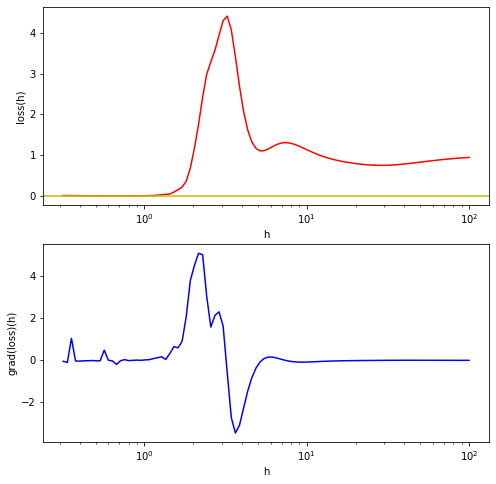

In [8]:
makeplots(slog.transpose(), bandwidth_grid, xscale="log", style="")

## Linear plots

In [9]:
rkey = random.PRNGKey(1)
bandwidth_grid = np.linspace(1, 7, num=grid_len) # NaNs when h < 0.25

In [10]:
sl = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m)

100it [02:08,  1.29s/it]
100it [02:58,  1.78s/it]
100it [02:26,  1.47s/it]
100it [02:15,  1.35s/it]
100it [02:35,  1.56s/it]
100it [02:37,  1.58s/it]
100it [02:47,  1.67s/it]
100it [02:34,  1.55s/it]
100it [02:39,  1.59s/it]
100it [02:45,  1.66s/it]


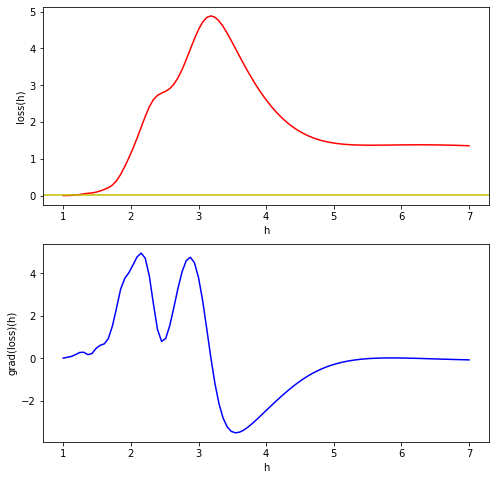

In [11]:
makeplots(sl.transpose(), bandwidth_grid, style="")

## Vary KSD parameter jointly with SVGD parameter

In [12]:
grid_len = 100
rkey = random.PRNGKey(0)
bandwidth_grid = np.linspace(0.3, 1, num=grid_len) # NaNs when h < 0.25

In [13]:
sll = sweep(rkey, bandwidth_grid)

100it [02:41,  1.62s/it]


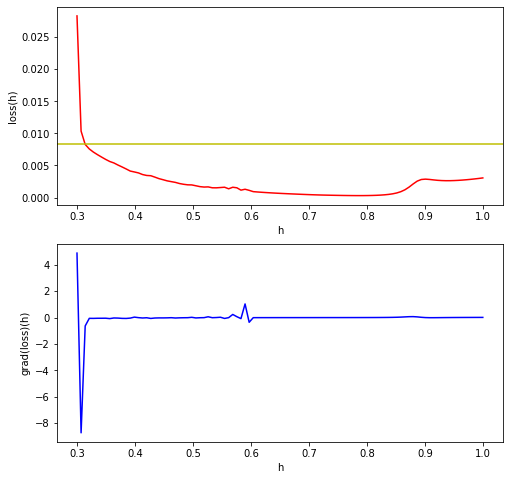

In [14]:
makeplots(sll.transpose(), bandwidth_grid, style="")

In [15]:
rkey = random.PRNGKey(0)
bandwidth_grid = np.linspace(0.3, 0.8, num=grid_len) # NaNs when h < 0.25

In [16]:
sjoint = sweep(rkey, bandwidth_grid, joint_param=True)

100it [02:48,  1.68s/it]


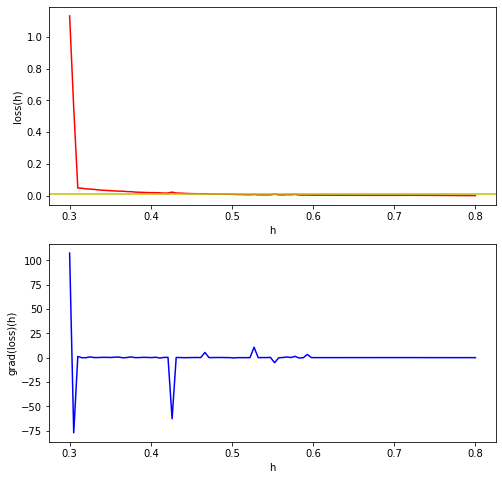

In [17]:
makeplots(sjoint.transpose(), bandwidth_grid, style="")

## Do some gradient descent

In [3]:
meta_stepsize = 0.1
n_steps = 50

In [4]:
svgd_fix

In [5]:
h = 2.5
opt_h, log1 = svgd_fix.optimize_bandwidth(h, meta_stepsize, n_steps)

In [7]:
print("value:", opt_h)

value: 0.83794904


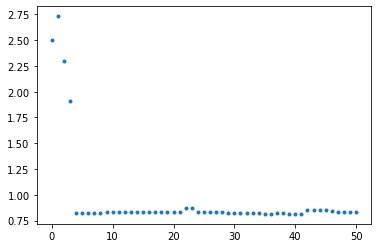

In [8]:
plt.plot(log1, ".")

In [10]:
h = 3
opt_h, log = svgd_fix.optimize_bandwidth(h, meta_stepsize, n_steps)
print("value:", opt_h)
# print(f"loss at {opt_h}:", svgd_fix.loss(rkey, opt_h))

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


value: 0.5465955


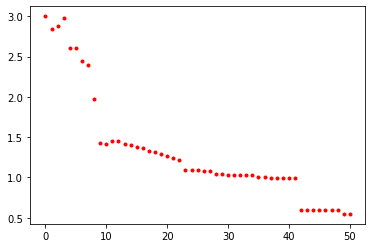

In [11]:
plt.plot(log, "r.")

Conclusion: gradient descent is succesful in finding decent local minima. But since the objective function (KSD) is nonconvex, it does sometimes get stuck in globally suboptimal spots.